In [26]:
import torch
import torch.nn as nn
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
from utils.toy_dataset import GaussianMixture
import math
import numpy as np
from sklearn.cluster import KMeans

In [27]:
## helper function
def linear_normalization(maxi, mini, target_max, target_min):
    alpha = (target_max - target_min)/(maxi - mini)
    beta = target_min - alpha*mini
    return alpha, beta

def normalize_diag(h, dataset_sample, mini=1e-4, maxi=2):
    all_h = h(dataset_sample)
    if len(all_h.shape)==2:
        print(f'normalizing diag metric')
        alpha, beta = [], []
        for i in range(all_h.shape[1]):
            alpha_, beta_ = linear_normalization(all_h[:,i].max(), all_h[:,i].min(), target_max=maxi,target_min=mini )
            alpha.append(alpha_)
            beta.append(beta_)
        alpha, beta = torch.stack(alpha), torch.stack(beta)
        return alpha.unsqueeze(0), beta.unsqueeze(0)

class h_diag_RBF(nn.Module):
    def __init__(self, n_centers, data_size=2, data_to_fit_ambiant=None, data_to_fit_latent=None, kappa=1):
        super().__init__()
        self.K = n_centers
        self.data_size = data_size
        self.kappa = kappa
        self.W = torch.nn.Parameter(torch.rand(self.K, 1))
        #sigmas = np.ones((self.K, 1))
        sigmas = np.ones((self.K, data_size))
        if (data_to_fit_ambiant is not None) and (data_to_fit_latent is not None):
            data_to_fit_a = data_to_fit_ambiant.cpu().detach().numpy()
            data_to_fit_l = data_to_fit_latent.cpu().detach().numpy()
            print("fitting")
            clustering_model = KMeans(n_clusters=self.K)
            clustering_model.fit(data_to_fit_a)
            clusters = clustering_model.cluster_centers_
            self.register_buffer('C', torch.tensor(clustering_model.cluster_centers_, dtype=torch.float32))
            labels = clustering_model.labels_
            for k in range(self.K):
                points = data_to_fit_l[labels == k]
                variance = ((points - clusters[k]) ** 2).mean(axis=0)
                #print('variance', variance.shape)
                sigmas[k, :] = np.sqrt(variance)
        else:
            self.register_buffer('C', torch.zeros(self.K, self.data_size))
        lbda = torch.tensor(0.5 / (self.kappa * sigmas) ** 2, dtype=torch.float32)
        self.register_buffer('lamda', lbda)
    
    def h(self, x_t):
        if len(x_t.shape) > 2:
            x_t = x_t.reshape(x.shape[0], -1)
        dist2 = torch.cdist(x_t, self.C) ** 2
        phi_x = torch.exp(-0.5 * self.lamda[None, :, :] * dist2[:, :, None])
        h_x = phi_x.sum(dim=1)
        return h_x

class h_diag_Land(nn.Module):
    def __init__(self, reference_sample, gamma = 0.2):
        super().__init__()
        self.reference_sample = reference_sample
        self.gamma = gamma
    

    def weighting_function(self, x):
        pairwise_sq_diff = (x[:, None, :] - self.reference_sample[None, :, :]) ** 2
        pairwise_sq_dist = pairwise_sq_diff.sum(-1)
        weights = torch.exp(-pairwise_sq_dist / (2 * self.gamma**2))
        return weights
    
    def h(self, x_t):
        weights = self.weighting_function(x_t)  # Shape [B, N]
        differences = self.reference_sample[None, :, :] - x_t[:, None, :]  # Shape [B, N, D]
        squared_differences = differences**2  # Shape [B, N, D]

        # Compute the sum of weighted squared differences for each dimension
        M_dd_diag = torch.einsum("bn,bnd->bd", weights, squared_differences)
        return M_dd_diag

class ConformalRiemannianMetric(nn.Module):
    def __init__(self, h, euclidian_weight=0):
        super().__init__()
        self.h = h
        self.euclidian_weight = euclidian_weight
    def g(self, x_t):
        return self.h(x_t)
        
    def kinetic(self, x_t, x_t_dot):
        g = self.g(x_t)
        return (self.euclidian_weight + g)*(x_t_dot.pow(2).sum(dim=-1))


class DiagonalRiemannianMetric(nn.Module):
    def __init__(self, h, euclid_weight=0):
        super().__init__()
        self.h = h
        self.euclid_weight = euclid_weight
        
    def g(self, x_t):
        return self.h(x_t)
        
    def kinetic(self, x_t, x_t_dot):
        g = self.g(x_t)
        return torch.einsum('bi,bi->b', x_t_dot, (self.euclid_weight + g) * x_t_dot)


class MLP_ELU_convex(nn.Module):
    def __init__(self):
        super(MLP_ELU_convex, self).__init__()
        self.f = nn.Sequential(
            nn.Linear(2, 32),
            nn.SiLU(),
            #nn.Tanh(),
            nn.Linear(32, 32),
            nn.SiLU(),
            #nn.Tanh(),
            nn.Linear(32, 32),
            nn.SiLU(),
            #nn.Tanh(),
            nn.Linear(32, 32),
            nn.SiLU(),
            #nn.Tanh(),
            nn.Linear(32, 32),
            nn.SiLU(),
            #nn.Tanh(),
            nn.Linear(32, 32)
            )
        self.f1 = nn.Linear(32, 1)
        self.f2 = nn.Linear(32, 1)
        self.f3 = nn.Linear(32, 1)
    
    def forward(self, x):
        out_feat = self.f(x)
        energy = self.f1(out_feat)*self.f2(out_feat) + self.f3(out_feat**2)
        return energy.squeeze()

In [28]:
## Gaussian Mixture Uniformly distributed

In [29]:
NB_GAUSSIANS = 200
RADIUS = 8
DEVICE = "cuda:1"
mean_ = (torch.linspace(0, 180, NB_GAUSSIANS + 1)[0:-1] * math.pi / 180)
MEAN = RADIUS * torch.stack([torch.cos(mean_), torch.sin(mean_)], dim=1)
COVAR = torch.tensor([[1., 0], [0, 1.]]).unsqueeze(0).repeat(len(MEAN), 1, 1)

x_p, y_p = torch.meshgrid(torch.linspace(-10, 10, 100), torch.linspace(-2.5, 10, 62), indexing='xy')
pos = torch.cat([x_p.flatten().unsqueeze(1), y_p.flatten().unsqueeze(1)], dim=1).to(DEVICE)

## Defining the mixture
weight_1 = (torch.ones(NB_GAUSSIANS) / NB_GAUSSIANS)
mixture_1 = GaussianMixture(center_data=MEAN, covar=COVAR, weight=weight_1).to(DEVICE)

## compute the energy landscape
energy_landscape_1 = mixture_1.energy(pos)

T_STEPS=50
dt = 1.0/(T_STEPS-1)

In [30]:
sample_dataset = mixture_1.sample(1000).to(DEVICE)
reference_samples = mixture_1.sample(1000)
## ebm-based metric
loaded = torch.load("./EBM_mixture1.pth", weights_only=False)
ebm = loaded['type']()
ebm.load_state_dict(loaded['weight'])
ebm.to(DEVICE)
#energy_function = lambda x: ebm(x).pow(10).sum(dim=1)

## Metric based on 1/p
true_p = lambda x: mixture_1.prob(x) ## works
p_max, p_min = true_p(pos).max().item(), true_p(pos).min().item() 
alpha_p, beta_p = linear_normalization(p_max, p_min, 1, 1e-3)
true_p_n = lambda x: alpha_p*true_p(x) + beta_p
inv_p = lambda x: 1/true_p_n(x)
print(f"inv_p -- mini : {inv_p(pos).min():0.3f}, maxi : {inv_p(pos).max():0.3f}")


## Metric based on 1/exp(-E) (ebm)
ebm_p = lambda x: torch.exp(-ebm(x))
ebm_p_max, ebm_p_min = ebm_p(pos).max().item(), ebm_p(pos).min().item()
alpha_ebm_p, beta_ebm_p = linear_normalization(ebm_p_max, ebm_p_min, 1, 1e-3)
ebm_p_n = lambda x: alpha_ebm_p*ebm_p(x) + beta_ebm_p
inv_ebm_p = lambda x: 1/ebm_p_n(x)
print(f"inv_ebm_p -- mini : {inv_ebm_p(pos).min():0.3f}, maxi : {inv_ebm_p(pos).max():0.3f}")

## Metric based on logp
true_en = lambda x: -torch.log(mixture_1.prob(x))
en_max, en_min = true_en(pos).max().item(), true_en(pos).min().item() 
alpha_en, beta_en = linear_normalization(en_max, en_min, 1e3, 0)
true_en_n = lambda x: 1 + alpha_en*true_en(x) + beta_en
print(f"true_en_n -- mini : {true_en_n(pos).min():0.3f}, maxi : {true_en_n(pos).max():0.3f}")

## Metric based on E (ebm)
ebm_en = lambda x: ebm(x)
ebm_en_max, ebm_en_min = ebm_en(pos).max().item(), ebm_en(pos).min().item()
alpha_ebm_en, beta_ebm_en = linear_normalization(ebm_en_max, ebm_en_min, 1e3, 0)
ebm_en_n = lambda x: 1 + alpha_ebm_en*ebm_en(x) + beta_ebm_en
print(f"ebm_en_n -- mini : {ebm_en_n(pos).min():0.3f}, maxi : {ebm_en_n(pos).max():0.3f}")


### land metric
h_land = h_diag_Land(reference_samples, gamma=1)
alpha_land, beta_land = normalize_diag(h_land.h, pos, mini=1e-3, maxi=1)
land_n = lambda x: 1/(alpha_land*h_land.h(x) + beta_land)
print(f"g_land -- mini : {land_n(pos).min()}, maxi : {land_n(pos).max()}")

### rbf metric
h_rbf = h_diag_RBF(n_centers = 30,  data_to_fit_ambiant=reference_samples, data_to_fit_latent=reference_samples).to(DEVICE)
alpha_rbf, beta_rbf = normalize_diag(h_rbf.h, pos, mini=1e-3, maxi=1)
rbf_n = lambda x: 1/(alpha_rbf*h_rbf.h(x) + beta_rbf)
print(f"g_rbf -- mini : {rbf_n(pos).min()}, maxi : {rbf_n(pos).max()}")

dico_metric_unif = {
    "diag_rbf_invp" : DiagonalRiemannianMetric(rbf_n),
    "conf_ebm_invp": ConformalRiemannianMetric(inv_ebm_p),
    "conf_true_invp": ConformalRiemannianMetric(inv_p),
    "conf_ebm_logp": ConformalRiemannianMetric(ebm_en_n),
    "conf_true_logp": ConformalRiemannianMetric(true_en_n), 
    "diag_land_invp": DiagonalRiemannianMetric(land_n),
} 
   
    

inv_p -- mini : 1.000, maxi : 1000.000
inv_ebm_p -- mini : 1.000, maxi : 1000.000
true_en_n -- mini : 1.000, maxi : 1001.000
ebm_en_n -- mini : 1.000, maxi : 1001.000
normalizing diag metric
g_land -- mini : 1.0, maxi : 999.9999389648438
fitting
normalizing diag metric
g_rbf -- mini : 1.0, maxi : 999.9999389648438


In [31]:
plot_init=True
T_STEPS=50
EPOCH = 50000
load = True

if not load:
    #EPOCH = 1
    dico_traj = {}
    
    for metric in dico_metric_unif.keys():
        print(f"\n\n {metric}")
        riemann_metric = dico_metric_unif[metric]
        
        z0 = MEAN[10].unsqueeze(0).to(DEVICE).detach()
        z1 = MEAN[-10].unsqueeze(0).to(DEVICE).detach()
        
        t = torch.linspace(0, 1, T_STEPS).unsqueeze(1).to(DEVICE).detach()
        dt = 1.0/(T_STEPS-1)
        
        z_t = z_t = (1-t)*z0 + t*z1
        
        if plot_init:
            all_angle = -torch.linspace(-math.pi, 0, T_STEPS)
            z_ideal = RADIUS * torch.stack([torch.cos(all_angle), torch.sin(all_angle)], dim=1).to(DEVICE)
            z_ideal_dot = (z_ideal[1:] - z_ideal[:-1])/dt
            z_t_dot = (z_t[1:] - z_t[:-1])/dt
            ## g and remanian metric on the ideal trajectory
            g_opt = riemann_metric.g(z_ideal)
            kinectic_opt = riemann_metric.kinetic(z_ideal[:-1], z_ideal_dot)
            ## g and remanian metric on the initial trajectory
            g_init = riemann_metric.g(z_t)
            kinectic_init = riemann_metric.kinetic(z_t[:-1], z_t_dot )
            fig, ax = plt.subplots(1, 4, figsize=(4*4, 4), dpi=100)
            ax[0].plot(g_opt.cpu().detach())
            ax[0].set_title('g on ideal traj')
            ax[1].plot(g_init.cpu().detach())
            ax[1].set_title('g on init traj')
            ax[2].plot(kinectic_opt.cpu().detach())
            ax[2].set_title('kinetic on ideal traj')
            ax[3].plot(kinectic_init.cpu().detach())
            ax[3].set_title('kinetic on init traj')
            plt.show()
            print(f'MIN : g_opt = {g_opt.min().item():0.3f} -- g_init = {g_init.min().item():0.3f}')
            print(f'MAX : g_opt = {g_opt.max().item():0.3f} -- g_init = {g_init.max().item():0.3f}')
            print(f'MEAN : g_opt = {g_opt.mean().item():0.3f} -- g_init = {g_init.mean().item():0.3f}')
            print(f'kinetic_opt = {kinectic_opt.mean().item():0.3f} -- kinectic_init = {kinectic_init.mean().item():0.3f}')
        
        z_i = z_t[1:-1].requires_grad_(True)
        optimizer = torch.optim.Adam([z_i], lr=1e-3)
        all_loss = []
        
        for ep in range(EPOCH):
            optimizer.zero_grad()
            z_t = torch.cat([z0,z_i,z1])
            z_t_dot = (z_t[1:] - z_t[:-1])/dt
            energy = riemann_metric.kinetic(z_t[:-1], z_t_dot)
            z_t_inv = torch.flip(z_t, dims=[0])
            z_t_dot_inv = (z_t_inv[1:] - z_t_inv[:-1])/dt
            energy_inv = riemann_metric.kinetic(z_t_inv[:-1], z_t_dot_inv)
        
            total_energy = (energy + energy_inv)/2
            #total_energy = energy
            loss = (total_energy*dt).sum()
            loss.backward()
            
            all_param = 0.0
            with torch.no_grad():
                all_param+=z_i.grad.norm()
            optimizer.step()
            all_loss.append(loss.item())
        
            with torch.no_grad():
                if ep % 10000 == 0:
                    print(f"{ep+1}/{EPOCH}")
                    fig, ax = plt.subplots(1, 2, figsize=(2*5,3), dpi=100)
                    ax[0].plot(all_loss)
                    ax[0].set_title('loss (kinectic)')
                    im = ax[1].contourf(x_p, y_p, energy_landscape_1.view(62, 100).detach().cpu(), 20,
                                cmap='Blues_r',
                                alpha=0.8,
                                zorder=0,
                                levels=20)
                    z_t = z_t.cpu().detach()
                    ax[1].scatter(z_t[1:-1,0], z_t[1:-1,1], s=2, color='black', alpha=1)
                    ax[1].scatter(z_t[0,0], z_t[0,1], s=10, color='red', alpha=1)
                    ax[1].scatter(z_t[-1,0], z_t[-1,1], s=10, color='green', alpha=1)
                    ax[1].set_axis_off()
                    
                    plt.show()
        dico_traj[metric] =  z_t.cpu().detach()    
    torch.save(dico_traj, "./ConfMetric_traj_uniform.dico")
else :
    dico_traj = torch.load("./ConfMetric_traj_uniform.dico", weights_only=False)
        

diag_rbf_invp
conf_ebm_invp
conf_true_invp
conf_ebm_logp
conf_true_logp
diag_land_invp


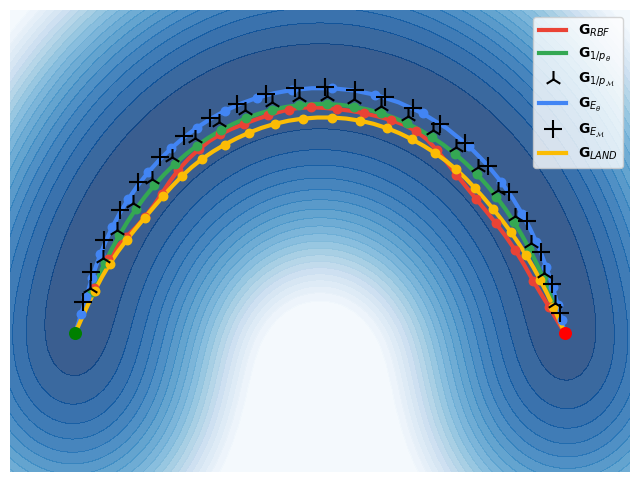

In [44]:
dico_color={
     "conf_ebm_logp": [(0.2588, 0.5216, 0.9569), 150, '.', r"$\mathbf{G}_{E_{\theta}}$"], ## blue google (66, 133, 244)
    "conf_ebm_invp": [(0.2039, 0.6588, 0.3255), 150,'.', r"$\mathbf{G}_{1/p_{\theta}}$"], #r"$h(x) \propto 1 / \exp(-E_{\theta}(x))$"], ## green google (52, 168, 83)
    "diag_rbf_invp":[(0.9176, 0.2627, 0.2078), 150,'.', r"$\mathbf{G}_{RBF}$"], #r"$h(x) \propto h_{RBF}$"], ## red google (234, 67, 53)
    "diag_land_invp":[(0.9843, 0.7373, 0.0196), 150,'.', r"$\mathbf{G}_{LAND}$"], ## yellow google (251, 188, 5)
    "conf_true_logp": ['black',150,'+' , r"$\mathbf{G}_{E_{\mathcal{M}}}$"],
    "conf_true_invp": ['black',150, '2', r"$\mathbf{G}_{1/p_{\mathcal{M}}}$"],
   
}

fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=100)
im = ax.contourf(x_p, y_p, energy_landscape_1.view(62, 100).detach().cpu(), 20,
                            cmap='Blues_r',
                            alpha=0.8,
                            zorder=0,
                            levels=20)
color = ['orange', 'black', 'grey', 'red', 'green','purple','pink','yellow']

reg_space = torch.linspace(0, T_STEPS - 1, 25).long()
for idx, metric in enumerate(dico_traj.keys()):
    print(metric)
    z_t = dico_traj[metric]
    z_t_scat = z_t[reg_space]
    if metric in ['conf_true_logp', 'conf_true_invp']:
        ax.scatter(z_t_scat[1:-1, 0], z_t_scat[1:-1, 1], color=dico_color[metric][0], alpha=1,
                      s=dico_color[metric][1], marker=dico_color[metric][2], label=dico_color[metric][3], zorder=3)
    else:
        ax.plot(z_t[:, 0], z_t[:, 1], color=dico_color[metric][0], linewidth=3, zorder=1,label=dico_color[metric][3], alpha=1)
        ax.scatter(z_t_scat[1:-1, 0], z_t_scat[1:-1, 1], color=dico_color[metric][0], alpha=1,
                      s=dico_color[metric][1], marker=dico_color[metric][2], zorder=2)
        
    #ax.scatter(z_t[1:-1,0], z_t[1:-1,1], s=10, color=dico_color[metric][0], alpha=1, label=str(metric))
    #ax.scatter(z_t[0,0], z_t[0,1], s=10, color='red', alpha=1)
    #ax.scatter(z_t[-1,0], z_t[-1,1], s=10, color='green', alpha=1)
# Add red and green dots
ax.scatter(MEAN[10][0].cpu().detach(), MEAN[10][1].cpu().detach(), s=70, color='red',alpha=1)
ax.scatter(MEAN[-10][0].cpu().detach(), MEAN[-10][1].cpu().detach(), s=70, color='green',alpha=1)
ax.set_axis_off()
plt.legend()
plt.show()

In [45]:
NB_GAUSSIANS = 200
RADIUS = 8
DEVICE = "cuda:1"
mean_ = (torch.linspace(0, 180, NB_GAUSSIANS + 1)[0:-1] * math.pi / 180)
MEAN = RADIUS * torch.stack([torch.cos(mean_), torch.sin(mean_)], dim=1)
COVAR = torch.tensor([[1., 0], [0, 1.]]).unsqueeze(0).repeat(len(MEAN), 1, 1)

x_p, y_p = torch.meshgrid(torch.linspace(-10, 10, 100), torch.linspace(-2.5, 10, 62), indexing='xy')
pos = torch.cat([x_p.flatten().unsqueeze(1), y_p.flatten().unsqueeze(1)], dim=1).to(DEVICE)

## Defining the mixture
linspace = torch.cat([torch.linspace(1, 30, 90),torch.ones(11)*30])
coeff_weight = torch.cat([linspace, linspace[1:-1].flip(dims=(0,))])
coeff_weight = coeff_weight/coeff_weight.sum()


## compute the energy landscape
mixture_2 = GaussianMixture(center_data=MEAN, covar=COVAR, weight=coeff_weight).to(DEVICE)

## compute the energy landscape
energy_landscape_2 = mixture_2.energy(pos)

T_STEPS=50
dt = 1.0/(T_STEPS-1)

In [46]:
sample_dataset = mixture_2.sample(1000).to(DEVICE)
reference_samples = mixture_2.sample(1000)
## ebm-based metric
loaded = torch.load("./EBM_mixture2.pth", weights_only=False)
ebm = loaded['type']()
ebm.load_state_dict(loaded['weight'])
ebm.to(DEVICE)
#energy_function = lambda x: ebm(x).pow(10).sum(dim=1)

## Metric based on 1/p
true_p = lambda x: mixture_2.prob(x) ## works
p_max, p_min = true_p(pos).max().item(), true_p(pos).min().item() 
alpha_p, beta_p = linear_normalization(p_max, p_min, 1, 1e-3)
true_p_n = lambda x: alpha_p*true_p(x) + beta_p
inv_p = lambda x: 1/true_p_n(x)
print(f"inv_p -- mini : {inv_p(pos).min():0.3f}, maxi : {inv_p(pos).max():0.3f}")


## Metric based on 1/exp(-E) (ebm)
ebm_p = lambda x: torch.exp(-ebm(x))
ebm_p_max, ebm_p_min = ebm_p(pos).max().item(), ebm_p(pos).min().item()
alpha_ebm_p, beta_ebm_p = linear_normalization(ebm_p_max, ebm_p_min, 1, 1e-3)
ebm_p_n = lambda x: alpha_ebm_p*ebm_p(x) + beta_ebm_p
inv_ebm_p = lambda x: 1/ebm_p_n(x)
print(f"inv_ebm_p -- mini : {inv_ebm_p(pos).min():0.3f}, maxi : {inv_ebm_p(pos).max():0.3f}")

## Metric based on logp
true_en = lambda x: -torch.log(mixture_2.prob(x))
en_max, en_min = true_en(pos).max().item(), true_en(pos).min().item() 
alpha_en, beta_en = linear_normalization(en_max, en_min, 1e3, 0)
true_en_n = lambda x: 1 + alpha_en*true_en(x) + beta_en
print(f"true_en_n -- mini : {true_en_n(pos).min():0.3f}, maxi : {true_en_n(pos).max():0.3f}")


## Metric based on E (ebm)
ebm_en = lambda x: ebm(x).squeeze()
ebm_en_max, ebm_en_min = ebm_en(pos).max().item(), ebm_en(pos).min().item()
alpha_ebm_en, beta_ebm_en = linear_normalization(ebm_en_max, ebm_en_min, 1e3, 0)
ebm_en_n = lambda x: 1 + alpha_ebm_en*ebm_en(x) + beta_ebm_en
print(alpha_ebm_en, beta_ebm_en)
print(f"ebm_en_n -- mini : {ebm_en_n(pos).min():0.3f}, maxi : {ebm_en_n(pos).max():0.3f}")


### land metric
h_land = h_diag_Land(reference_samples, gamma=1)
alpha_land, beta_land = normalize_diag(h_land.h, pos, mini=1e-3, maxi=1)
land_n = lambda x: 1/(alpha_land*h_land.h(x) + beta_land)
print(f"g_land -- mini : {land_n(pos).min()}, maxi : {land_n(pos).max()}")

### rbf metric
h_rbf = h_diag_RBF(n_centers = 50,  data_to_fit_ambiant=reference_samples, data_to_fit_latent=reference_samples).to(DEVICE)
alpha_rbf, beta_rbf = normalize_diag(h_rbf.h, pos, mini=1e-3, maxi=1)
rbf_n = lambda x: 1/(alpha_rbf*h_rbf.h(x) + beta_rbf)
print(f"g_rbf -- mini : {rbf_n(pos).min()}, maxi : {rbf_n(pos).max()}")

dico_metric_non_unif = {
    "diag_rbf_invp" : DiagonalRiemannianMetric(rbf_n),
    "conf_ebm_logp": ConformalRiemannianMetric(ebm_en_n),
    "conf_true_logp": ConformalRiemannianMetric(true_en_n), 
    
    "conf_ebm_invp": ConformalRiemannianMetric(inv_ebm_p),
    "conf_true_invp": ConformalRiemannianMetric(inv_p),
    
    "diag_land_invp": DiagonalRiemannianMetric(land_n),
    
} 
   
    

inv_p -- mini : 1.000, maxi : 1000.000
inv_ebm_p -- mini : 1.000, maxi : 1000.000
true_en_n -- mini : 1.000, maxi : 1001.000
103.73633791253158 53.878211619936536
ebm_en_n -- mini : 1.000, maxi : 1001.000
normalizing diag metric
g_land -- mini : 1.0, maxi : 999.9999389648438
fitting
normalizing diag metric
g_rbf -- mini : 0.9999998807907104, maxi : 999.9999389648438


In [47]:
plot_init=True
T_STEPS=50
EPOCH = 50000
load = True

if not load:
    #EPOCH = 1
    dico_traj_2 = {}
    
    for metric in dico_metric_non_unif.keys():
        print(f"\n\n {metric}")
        riemann_metric = dico_metric_non_unif[metric]
        
        z0 = MEAN[10].unsqueeze(0).to(DEVICE).detach()
        z1 = MEAN[-10].unsqueeze(0).to(DEVICE).detach()
        
        t = torch.linspace(0, 1, T_STEPS).unsqueeze(1).to(DEVICE).detach()
        dt = 1.0/(T_STEPS-1)
        
        z_t = z_t = (1-t)*z0 + t*z1
        
        if plot_init:
            all_angle = -torch.linspace(-math.pi, 0, T_STEPS)
            z_ideal = RADIUS * torch.stack([torch.cos(all_angle), torch.sin(all_angle)], dim=1).to(DEVICE)
            z_ideal_dot = (z_ideal[1:] - z_ideal[:-1])/dt
            z_t_dot = (z_t[1:] - z_t[:-1])/dt
            ## g and remanian metric on the ideal trajectory
            g_opt = riemann_metric.g(z_ideal)
            kinectic_opt = riemann_metric.kinetic(z_ideal[:-1], z_ideal_dot)
            ## g and remanian metric on the initial trajectory
            g_init = riemann_metric.g(z_t)
            kinectic_init = riemann_metric.kinetic(z_t[:-1], z_t_dot )
            fig, ax = plt.subplots(1, 4, figsize=(4*4, 4), dpi=100)
            ax[0].plot(g_opt.cpu().detach())
            ax[0].set_title('g on ideal traj')
            ax[1].plot(g_init.cpu().detach())
            ax[1].set_title('g on init traj')
            ax[2].plot(kinectic_opt.cpu().detach())
            ax[2].set_title('kinetic on ideal traj')
            ax[3].plot(kinectic_init.cpu().detach())
            ax[3].set_title('kinetic on init traj')
            plt.show()
            print(f'MIN : g_opt = {g_opt.min().item():0.3f} -- g_init = {g_init.min().item():0.3f}')
            print(f'MAX : g_opt = {g_opt.max().item():0.3f} -- g_init = {g_init.max().item():0.3f}')
            print(f'MEAN : g_opt = {g_opt.mean().item():0.3f} -- g_init = {g_init.mean().item():0.3f}')
            print(f'kinetic_opt = {kinectic_opt.mean().item():0.3f} -- kinectic_init = {kinectic_init.mean().item():0.3f}')
        
        z_i = z_t[1:-1].requires_grad_(True)
        optimizer = torch.optim.Adam([z_i], lr=1e-3)
        all_loss = []
        
        for ep in range(EPOCH):
            optimizer.zero_grad()
            z_t = torch.cat([z0,z_i,z1])
            z_t_dot = (z_t[1:] - z_t[:-1])/dt
            energy = riemann_metric.kinetic(z_t[:-1], z_t_dot)
        
            z_t_inv = torch.flip(z_t, dims=[0])
            z_t_dot_inv = (z_t_inv[1:] - z_t_inv[:-1])/dt
            energy_inv = riemann_metric.kinetic(z_t_inv[:-1], z_t_dot_inv)
        
            total_energy = (energy + energy_inv)/2
            #total_energy = energy
            loss = (total_energy*dt).sum()
            loss.backward()
            
            all_param = 0.0
            with torch.no_grad():
                all_param+=z_i.grad.norm()
            optimizer.step()
            all_loss.append(loss.item())
        
            with torch.no_grad():
                if ep % 10000 == 0:
                    print(f"{ep+1}/{EPOCH}")
                    fig, ax = plt.subplots(1, 3, figsize=(3*5,3), dpi=100)
                    ax[0].plot(all_loss)
                    ax[0].set_title('loss (kinectic)')
                    im = ax[1].contourf(x_p, y_p, energy_landscape_2.view(62, 100).detach().cpu(), 20,
                                cmap='Blues_r',
                                alpha=0.8,
                                zorder=0,
                                levels=20)
                    z_t = z_t.cpu().detach()
                    ax[1].scatter(z_t[1:-1,0], z_t[1:-1,1], s=2, color='black', alpha=1)
                    ax[1].scatter(z_t[0,0], z_t[0,1], s=10, color='red', alpha=1)
                    ax[1].scatter(z_t[-1,0], z_t[-1,1], s=10, color='green', alpha=1)
                    
                    ax[1].set_axis_off()
                    ax[2].plot(total_energy.cpu().detach())
                    
                    plt.show()
        dico_traj_2[metric] =  z_t.cpu().detach()    
    torch.save(dico_traj_2, "./ConfMetric_traj_non_uniform_FINALV2.dico")
else :
    dico_traj_2 = torch.load("./ConfMetric_traj_non_uniform_FINALV2.dico", weights_only=False)
        

diag_rbf_invp
conf_ebm_logp
conf_true_logp
conf_ebm_invp
conf_true_invp
diag_land_invp


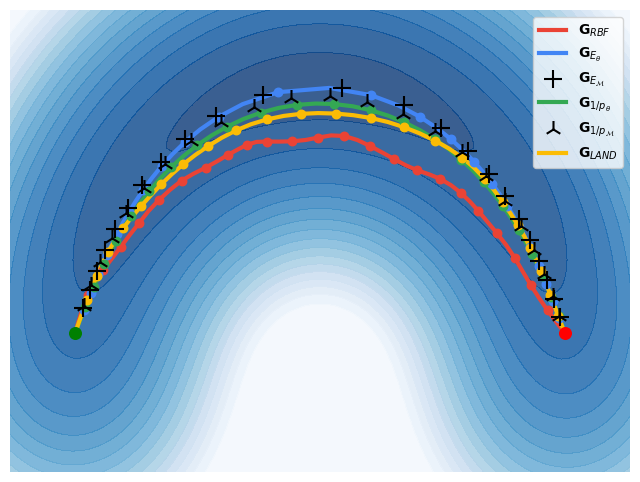

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=100)
im = ax.contourf(x_p, y_p, energy_landscape_2.view(62, 100).detach().cpu(), 20,
                            cmap='Blues_r',
                            alpha=0.8,
                            zorder=0,
                            levels=20)
color = ['orange', 'black', 'grey', 'red', 'green','purple','pink','yellow']

reg_space = torch.linspace(0, T_STEPS - 1, 25).long()
for idx, metric in enumerate(dico_traj_2.keys()):
    print(metric)
    z_t = dico_traj_2[metric]
    z_t_scat = z_t[reg_space]
    if metric in ['conf_true_logp', 'conf_true_invp']:
        ax.scatter(z_t_scat[1:-1, 0], z_t_scat[1:-1, 1], color=dico_color[metric][0], alpha=1,
                      s=dico_color[metric][1], marker=dico_color[metric][2], label=dico_color[metric][3], zorder=3)
    else:
        ax.plot(z_t[:, 0], z_t[:, 1], color=dico_color[metric][0], linewidth=3, zorder=1,label=dico_color[metric][3], alpha=1)
        ax.scatter(z_t_scat[1:-1, 0], z_t_scat[1:-1, 1], color=dico_color[metric][0], alpha=1,
                      s=dico_color[metric][1], marker=dico_color[metric][2], zorder=2)
        
    #ax.scatter(z_t[1:-1,0], z_t[1:-1,1], s=10, color=dico_color[metric][0], alpha=1, label=str(metric))
    #ax.scatter(z_t[0,0], z_t[0,1], s=10, color='red', alpha=1)
    #ax.scatter(z_t[-1,0], z_t[-1,1], s=10, color='green', alpha=1)
# Add red and green dots
ax.scatter(MEAN[10][0].cpu().detach(), MEAN[10][1].cpu().detach(), s=70, color='red',alpha=1)
ax.scatter(MEAN[-10][0].cpu().detach(), MEAN[-10][1].cpu().detach(), s=70, color='green',alpha=1)
ax.set_axis_off()
plt.legend()
plt.show()
